<a href="https://colab.research.google.com/github/yuyunchia/kws-streaming/blob/main/kws_streaming/colab/00_check_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

Make sure that jupyter is installed by running below command (it will allow to create folders in user dir):

```shell
pip install jupyter --user
```

## Set up environment
## from kws_experiments_12_labels.md

Set main folder.

In [ ]:
# create main folder
%mkdir test

# set path to a main folder
!KWS_PATH=$PWD/test

%cd $KWS_PATH
# copy content of kws_streaming to a folder /tmp/test/kws_streaming
!git clone https://github.com/google-research/google-research.git
%mv google-research/kws_streaming .







### Install tensorflow with deps.

# set up virtual env
!pip install virtualenv
!virtualenv --system-site-packages -p python3 ./venv3
!source ./venv3/bin/activate

# install TensorFlow, correct TensorFlow version is important
!pip install --upgrade pip
!pip install tf_nightly
!pip install tensorflow_addons
!pip install tensorflow_model_optimization
# was tested on tf_nightly-2.3.0.dev20200515-cp36-cp36m-manylinux2010_x86_64.whl

# install libs:
!pip install pydot
!pip install graphviz
!pip install numpy
!pip install absl-py





### Set up data sets:
# download and set up path to data set V2 and set it up
!wget https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
%mkdir data2
%mv ./speech_commands_v0.02.tar.gz ./data2
%cd ./data2
!tar -xf ./speech_commands_v0.02.tar.gz
%cd ../

# path to data sets V2






### Set path to models:
# set up path for model training
%mkdir $KWS_PATH/models_data_v2_12_labels

# models trained on data V2
!MODELS_PATH=$KWS_PATH/models_data_v2_12_labels








### Models training and evaluation:

# CMD_TRAIN="bazel run -c opt --copt=-mavx2 kws_streaming/train:model_train_eval --"
!CMD_TRAIN="python -m kws_streaming.train.model_train_eval"


## From 00_check.ipynb

In [ ]:
!pip install jupyter --user

In [ ]:
## !git clone https://github.com/google-research/google-research.git

In [ ]:
import sys
import os
import tarfile
import urllib

## from 01_train
import zipfile


sys.path.append('./google-research')

## some change


In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # no need to use gpu

In [ ]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_flags
from kws_streaming.models import models
from kws_streaming.layers.modes import Modes
from kws_streaming.train import test
from kws_streaming.models import utils
from kws_streaming.data import input_data
from kws_streaming.data import input_data_utils as du
from kws_streaming.models import model_params

In [ ]:
tf1.__version__

In [ ]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

In [ ]:
tf1.disable_eager_execution()

In [ ]:
DATA_VERSION = 2

In [ ]:
current_dir = os.getcwd()

if DATA_VERSION == 2:
  DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
  DATA_PATH = os.path.join(current_dir, "data2/")
elif DATA_VERSION == 1:
  DATA_URL = "http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz"
  DATA_PATH = os.path.join(current_dir, "data1/")
else:
  assert(False)

In [ ]:
DATA_PATH

In [ ]:
# create folder in current dir.
# not data will be downloaded in DATA_PATH, feel free to specify your own DATA_PATH
os.makedirs(DATA_PATH)

In [ ]:
base_name = os.path.basename(DATA_URL)
base_name

In [ ]:
# it can take some time to download 2.3GB. After unpacking total size is 5.4GB
arch_file_name = os.path.join(DATA_PATH, base_name)
if not os.path.isfile(arch_file_name):
  # download data
  if sys.version_info >= (2, 5):
    file_path = urllib.request.urlretrieve(DATA_URL, filename=arch_file_name)[0]
  else:
    file_path = urllib.urlretrieve(DATA_URL, filename=arch_file_name)[0]

  # unpack it
  file_name, file_extension = os.path.splitext(base_name)
  tar = tarfile.open(file_path)
  tar.extractall(DATA_PATH)
  tar.close()

In [ ]:
# default parameters for data splitting
flags = model_params.Params()
flags.data_dir = DATA_PATH
flags.data_url = DATA_URL
flags = model_flags.update_flags(flags)

In [ ]:
audio_processor = input_data.AudioProcessor(flags)

In [ ]:
testing_set_size = audio_processor.set_size('testing')
print("testing_set_size " + str(testing_set_size))
training_set_size = audio_processor.set_size('training')
print("training_set_size " + str(training_set_size))
validation_set_size = audio_processor.set_size('validation')
print("validation_set_size " + str(validation_set_size))

In [ ]:
# V2
# testing_set_size 4890
# training_set_size 36923
# validation_set_size 4445

# V1
# testing_set_size 3081
# training_set_size 22246
# validation_set_size 3093

In [ ]:
# all words used for modeling: we have target words + unknown words (with index 1)
audio_processor.word_to_index

In [ ]:
# find the start of the file name where label begins
string = audio_processor.data_index["validation"][0]['file']
res = [i for i in range(len(string)) if string.startswith('/', i)] 
start_file = res[-2]+1
start_file

In [ ]:
audio_processor.data_index["validation"][0]['file'][start_file:]

In [ ]:
index_to_label = {}
unknown_category = []
# labeles used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == du.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = du.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == du.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = du.UNKNOWN_WORD_LABEL
    unknown_category.append(word)
  else:
    index_to_label[audio_processor.word_to_index[word]] = word

# training labels
index_to_label

In [ ]:
# words belonging to unknown categry
unknown_category

In [ ]:
def get_distribution(mode):
  distrib_label = {}
  distrib_words = {}
  files = {}
  for data in audio_processor.data_index[mode]:
    word = data['label']
    file = data['file'][start_file:]
    index = audio_processor.word_to_index[word]
    label = index_to_label[index]
    if word in files:
      files[word].append(file)
    else:
      files[word] = [file]

    if label in distrib_label:
      distrib_label[label] = distrib_label[label] + 1
    else:
      distrib_label[label] = 0

    if word in distrib_words:
      distrib_words[word] = distrib_words[word] + 1
    else:
      distrib_words[word] = 0
  return distrib_words, distrib_label, files

In [ ]:
# distribution of labeles in testing data
distrib_words_testing, distrib_labels_testing, files_testing = get_distribution('testing')
distrib_labels_testing

In [ ]:
# distribution of labeles in training data
distrib_words_training, distrib_labels_training, files_training = get_distribution('training')
distrib_labels_training

In [ ]:
def parse_files(set_list_fname, label='yes'):
  set_files = []
  with open(set_list_fname) as f:
    while True:
      line = f.readline()
      if not line:
        break
      if line.split('/')[0] == label:
        set_files.append(line[:-1])
  return set_files

In [ ]:
def validate(my_list1, list2, print_in_list2=False):
  cnt_my_val2 = 0
  cnt_my_val1 = 0
  for my_val in my_list1:
    if my_val in list2:
      cnt_my_val2 = cnt_my_val2 + 1
      if print_in_list2:
        print(my_val)
    else:
      cnt_my_val1 = cnt_my_val1 + 1
      if not print_in_list2:
        print(my_val)
  return cnt_my_val1, cnt_my_val2

In [ ]:
file_list = os.path.join(DATA_PATH, "testing_list.txt")

# validate that all wav used during testing belongs to testing_list
for word in files_testing.keys():
  if word != '_silence_':
    word_files = parse_files(file_list, label=word)
    _, cnt_val = validate(files_testing[word], word_files, False)
    assert(cnt_val-len(files_testing[word])==0)

In [ ]:

distrib_words_training, distrib_labels_training, files_training = get_distribution('training')

# validate that all wav used during testing do not belong to training data
for word in files_testing.keys():
  if word != '_silence_': # silence file does not matter becasue it is multiplied by zero
    word_files = files_testing[word]
    _, cnt_val = validate(files_training[word], word_files, True)
    assert(cnt_val == 0)

In [ ]:
##
## below is from 01_train.ipynb
##
##
##

In [ ]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.layers.modes import Modes

In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_flags
from kws_streaming.models import model_params
from kws_streaming.train import test
from kws_streaming.train import train
from kws_streaming import data
tf1.disable_eager_execution()

In [ ]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

In [ ]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [ ]:
tf.__version__

In [ ]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

# **Set path to data**

In [ ]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you already run "00_check-data.ipynb" then folder "data2" should be located in the current dir
current_dir = os.getcwd()
DATA_PATH = os.path.join(current_dir, "data2/")

In [ ]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  samplerate, wave_data = wav.read(filename)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
          round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [48]:
# Set path to wav file to visualize it
wav_file = os.path.join(DATA_PATH, "left/012187a4_nohash_0.wav")

# read audio file
wav_data, samplerate = wavread_as_float(wav_file)

In [49]:
assert samplerate == 16000

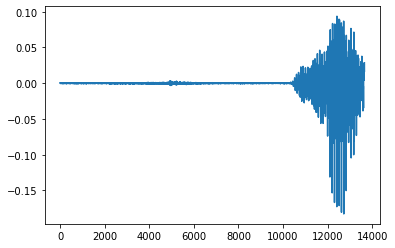

In [50]:
plt.plot(wav_data)

# **Set path to a model with config**

In [51]:
# select model name should be one of
model_params.HOTWORD_MODEL_PARAMS.keys()

dict_keys(['svdf', 'svdf_resnet', 'ds_cnn', 'gru', 'lstm', 'cnn_stride', 'cnn', 'tc_resnet', 'crnn', 'dnn', 'att_rnn', 'att_mh_rnn', 'mobilenet', 'mobilenet_v2', 'xception', 'inception', 'inception_resnet', 'ds_tc_resnet', 'bc_resnet'])

In [52]:
# This notebook is configured to work with 'ds_tc_resnet' and 'svdf'.
MODEL_NAME = 'ds_tc_resnet'
# MODEL_NAME = 'svdf'
MODELS_PATH = os.path.join(current_dir, "models")
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME + "/")
MODEL_PATH

'/content/data2/models/ds_tc_resnet/'

In [53]:
os.makedirs(MODEL_PATH)

In [54]:
# get toy model settings
FLAGS = model_params.HOTWORD_MODEL_PARAMS[MODEL_NAME]

In [55]:
# set path to data and model (where model will be stored)
FLAGS.data_dir = DATA_PATH
FLAGS.train_dir = MODEL_PATH

# set speech feature extractor properties
FLAGS.mel_upper_edge_hertz = 7600
FLAGS.window_size_ms = 30.0
FLAGS.window_stride_ms = 10.0
FLAGS.mel_num_bins = 80
FLAGS.dct_num_features = 40
FLAGS.feature_type = 'mfcc_tf'
FLAGS.preprocess = 'raw'

# for numerical correctness of streaming and non streaming models set it to 1
# but for real use case streaming set it to 0
FLAGS.causal_data_frame_padding = 0

FLAGS.use_tf_fft = True
FLAGS.mel_non_zero_only = not FLAGS.use_tf_fft

# set training settings
FLAGS.train = 1
# reduced number of training steps for test only
# so model accuracy will be low,
# to improve accuracy set how_many_training_steps = '40000,40000,20000,20000'
FLAGS.how_many_training_steps = '400,400,400,400'
FLAGS.learning_rate = '0.001,0.0005,0.0001,0.00002'
FLAGS.lr_schedule = 'linear'
FLAGS.verbosity = logging.INFO

# data augmentation parameters
FLAGS.resample = 0.15
FLAGS.time_shift_ms = 100
FLAGS.use_spec_augment = 1
FLAGS.time_masks_number = 2
FLAGS.time_mask_max_size = 25
FLAGS.frequency_masks_number = 2
FLAGS.frequency_mask_max_size = 7
FLAGS.pick_deterministically = 1

In [56]:
FLAGS.model_name = MODEL_NAME

# model parameters are different for every model
if MODEL_NAME == 'svdf':
  FLAGS.model_name = MODEL_NAME
  FLAGS.svdf_memory_size = "4,10,10,10,10,10"
  FLAGS.svdf_units1 = "16,32,32,32,64,128"
  FLAGS.svdf_act = "'relu','relu','relu','relu','relu','relu'"
  FLAGS.svdf_units2 = "40,40,64,64,64,-1"
  FLAGS.svdf_dropout = "0.0,0.0,0.0,0.0,0.0,0.0"
  FLAGS.svdf_pad = 0
  FLAGS.dropout1 = 0.0
  FLAGS.units2 = ''
  FLAGS.act2 = ''
elif MODEL_NAME == 'ds_tc_resnet':
  # it is an example of model streaming with strided convolution, strided pooling and dilated convolution
  FLAGS.activation = 'relu'
  FLAGS.dropout = 0.0
  FLAGS.ds_filters = '128, 64, 64, 64, 128, 128'
  FLAGS.ds_filter_separable = '1, 1, 1, 1, 1, 1'
  FLAGS.ds_repeat = '1, 1, 1, 1, 1, 1'
  FLAGS.ds_residual = '0, 1, 1, 1, 0, 0' # residual can not be applied with stride
#   FLAGS.ds_kernel_size = '11, 5, 15, 7, 29, 1'
  FLAGS.ds_kernel_size = '11, 5, 15, 17, 15, 1'
  FLAGS.ds_dilation = '1, 1, 1, 1, 2, 1'
  FLAGS.ds_stride = '1, 1, 1, 1, 1, 1'
  FLAGS.ds_pool = '1, 2, 1, 1, 1, 1'
  # model should be causal, so that we can covert it to streaming mode
  # if model is non causal then all non causal components should use Delay layer
  FLAGS.ds_padding = "'causal', 'causal', 'causal', 'causal', 'causal', 'causal'"
else:
  raise ValueError("set parameters for other models")

In [57]:
flags = model_flags.update_flags(FLAGS)

In [58]:
with open(os.path.join(flags.train_dir, 'flags.json'), 'wt') as f:
  json.dump(flags.__dict__, f)

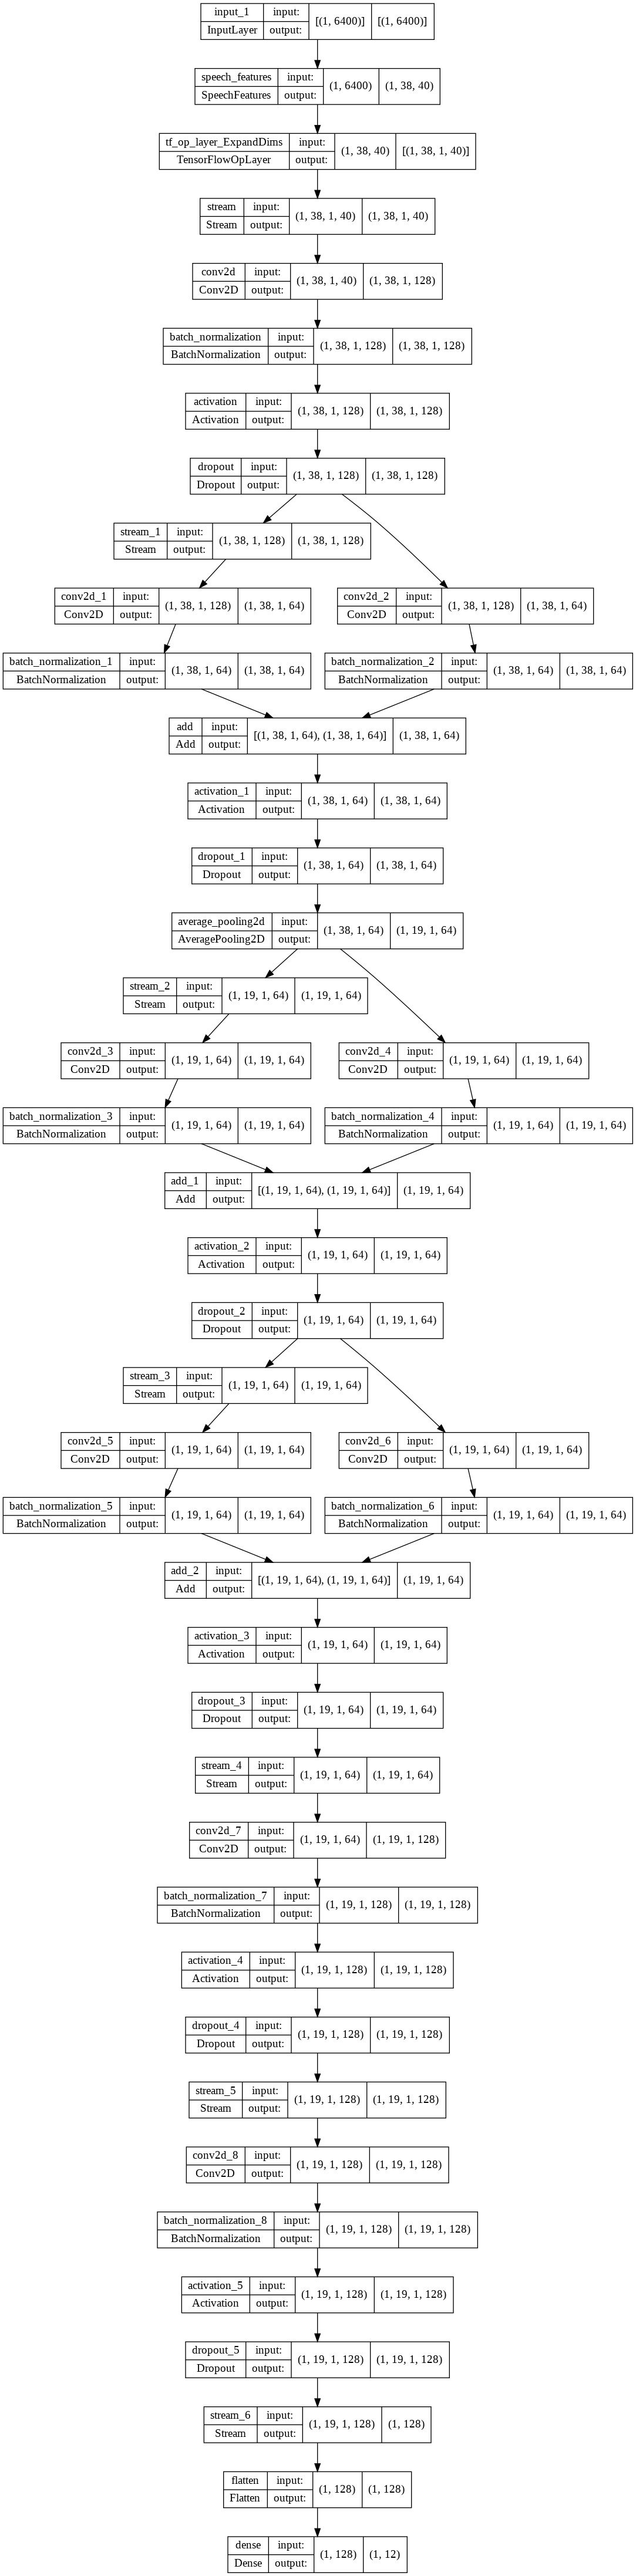

In [59]:
# visualize a model
model_non_stream_batch = models.MODELS[flags.model_name](flags)
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [60]:
model_non_stream_batch.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 6400)]          0           []                               
                                                                                                  
 speech_features (SpeechFeature  (1, 38, 40)         0           ['input_1[0][0]']                
 s)                                                                                               
                                                                                                  
 tf_op_layer_ExpandDims (Tensor  [(1, 38, 1, 40)]    0           ['speech_features[0][0]']        
 FlowOpLayer)                                                                                     
                                                                                              

# **Model training**

In [61]:
# Model training
train.train(flags)

INFO:absl:<kws_streaming.models.model_params.Params object at 0x7fe1d4a96750>


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.
INFO:absl:None


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(1, 6400)]          0           []                               
                                                                                                  
 speech_features (SpeechFeature  (1, 38, 40)         0           ['input_1[0][0]']                
 s)                                                                                               
                                                                                                  
 tf_op_layer_ExpandDims (Tensor  [(1, 38, 1, 40)]    0           ['speech_features[0][0]']        
 FlowOpLayer)                                                                                     
                                                                                              

INFO:absl:Training from step: 1 
INFO:absl:Step #1: rate 0.001000, accuracy 0.00%, cross entropy 2.552319
INFO:absl:Step #2: rate 0.001000, accuracy 0.00%, cross entropy 2.791292
INFO:absl:Step #3: rate 0.001000, accuracy 0.00%, cross entropy 2.751641
INFO:absl:Step #4: rate 0.001000, accuracy 0.00%, cross entropy 2.796972
INFO:absl:Step #5: rate 0.001000, accuracy 100.00%, cross entropy 1.898391
INFO:absl:Step #6: rate 0.001000, accuracy 0.00%, cross entropy 2.885908
INFO:absl:Step #7: rate 0.001000, accuracy 0.00%, cross entropy 2.567551
INFO:absl:Step #8: rate 0.001000, accuracy 100.00%, cross entropy 1.938580
INFO:absl:Step #9: rate 0.001000, accuracy 0.00%, cross entropy 2.823218
INFO:absl:Step #10: rate 0.001000, accuracy 0.00%, cross entropy 2.215343
INFO:absl:Step #11: rate 0.001000, accuracy 0.00%, cross entropy 2.457526
INFO:absl:Step #12: rate 0.001000, accuracy 0.00%, cross entropy 3.811072
INFO:absl:Step #13: rate 0.001000, accuracy 0.00%, cross entropy 2.451889
INFO:absl:

## **Run model evaluation**
### TF **Run non streaming inference**

In [62]:
folder_name = 'tf'
test.tf_non_stream_model_accuracy(flags, folder_name)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
INFO:absl:TF Final test accuracy on non stream model = 8.67% (N=4800)


8.666666666666668

more testing functions can be found at [test](https://github.com/google-research/google-research/blob/master/kws_streaming/train/test.py)

In [ ]:
##
## below is from 02_inference.ipynb
##

## Examples of streaming and non streaming inference with TF/TFlite

Imports

In [63]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.models import model_utils
from kws_streaming.layers.modes import Modes



import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_flags
from kws_streaming.models import model_params
from kws_streaming.train import inference
from kws_streaming.train import test
from kws_streaming.data import input_data
from kws_streaming.data import input_data_utils as du
tf1.disable_eager_execution()



config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)


# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal



tf.__version__



tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


## Load wav file

In [64]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  samplerate, wave_data = wav.read(filename)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
      round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [65]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you run 00_check-data.ipynb then data2 should be located in the current folder
current_dir = os.getcwd()
DATA_PATH = os.path.join(current_dir, "data2/")

In [66]:
# Set path to wav file for testing.
wav_file = os.path.join(DATA_PATH, "left/012187a4_nohash_0.wav")

# read audio file
wav_data, samplerate = wavread_as_float(wav_file)

In [67]:
assert samplerate == 16000

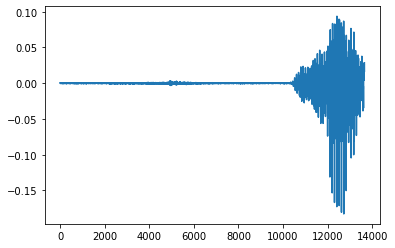

In [68]:
plt.plot(wav_data)

## Prepare batched mode

In [69]:
# This notebook is configured to work with 'ds_tc_resnet' and 'svdf'.
MODEL_NAME = 'ds_tc_resnet'
# MODEL_NAME = 'svdf'
MODELS_PATH = os.path.join(current_dir, "models")
MODEL_PATH = os.path.join(MODELS_PATH, MODEL_NAME + "/")
MODEL_PATH

'/content/data2/models/ds_tc_resnet/'

In [71]:
train_dir = os.path.join(MODELS_PATH, MODEL_NAME)

In [72]:
# below is another way of reading flags - through json
with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.json'), 'r') as fd:
  flags_json = json.load(fd)

class DictStruct(object):
  def __init__(self, **entries):
    self.__dict__.update(entries)

flags = DictStruct(**flags_json)

In [73]:
flags.data_dir = DATA_PATH

In [74]:
# get total stride of the model

total_stride = 1
if MODEL_NAME == 'ds_tc_resnet':
  # it can be automated by scanning layers of the model, but for now just use parameters of specific model
  pools = model_utils.parse(flags.ds_pool)
  strides = model_utils.parse(flags.ds_stride)
  time_stride = [1]
  for pool in pools:
    if pool > 1:
      time_stride.append(pool)
  for stride in strides:
    if stride > 1:
      time_stride.append(stride)
  total_stride = np.prod(time_stride)

# overide input data shape for streaming model with stride/pool
flags.data_stride = total_stride
flags.data_shape = (total_stride * flags.window_stride_samples,)

In [75]:
# prepare mapping of index to word
audio_processor = input_data.AudioProcessor(flags)
index_to_label = {}
# labels used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == du.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = du.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == du.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = du.UNKNOWN_WORD_LABEL
  else:
    index_to_label[audio_processor.word_to_index[word]] = word

# training labels
index_to_label

{0: '_silence_',
 1: '_unknown_',
 2: 'yes',
 3: 'no',
 4: 'up',
 5: 'down',
 6: 'left',
 7: 'right',
 8: 'on',
 9: 'off',
 10: 'stop',
 11: 'go'}

In [91]:
# pad input audio with zeros, so that audio len = flags.desired_samples

print("flags.desired_samples: ",flags.desired_samples)
print("len(wav_data): ",len(wav_data))
##print("wav_data: ",wav_data)

def printwavdata(wav):
  for i in range(len(wav)):
    if wav[i] == 0:
      print(i)
  print("end")

printwavdata(wav_data)

###  originnal code but has error ,
###  padded_wav = np.pad(wav_data, (0, flags.desired_samples-len(wav_data)), 'constant')

### code by Toby
padded_wav = np.pad(wav_data, (0, flags.desired_samples), 'constant')


print("len(padded_wav): ",len(padded_wav))


input_data = np.expand_dims(padded_wav, 0)
input_data.shape

flags.desired_samples:  6400
len(wav_data):  13653
408
417
718
820
837
849
893
905
926
1000
1013
1105
1247
1250
1336
1343
1422
1524
1545
1619
1633
1648
1649
1650
1680
1929
1994
2018
2105
2212
2397
2415
2523
2599
2678
2732
3619
3852
4316
7644
8059
9263
10078
end
len(padded_wav):  20053


(1, 20053)

In [81]:
# create model with flag's parameters
model_non_stream_batch = models.MODELS[flags.model_name](flags)

# load model's weights
weights_name = 'best_weights'
model_non_stream_batch.load_weights(os.path.join(train_dir, weights_name))

In [ ]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

## Run inference with TF
##TF Run non streaming inference

In [84]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
#model_non_stream.summary()

/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [ ]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [86]:
predictions = model_non_stream.predict(input_data)
predicted_labels = np.argmax(predictions, axis=1)

ValueError: ignored

In [ ]:
predicted_labels

In [ ]:
index_to_label[predicted_labels[0]]

TF Run streaming inference with internal state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
#model_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
stream_output_prediction = inference.run_stream_inference_classification(flags, model_stream, input_data)

In [ ]:
stream_output_arg = np.argmax(stream_output_prediction)
stream_output_arg

In [ ]:
index_to_label[stream_output_arg]

TF Run streaming inference with external state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream_external = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
#model_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_stream_external,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
inputs = []
for s in range(len(model_stream_external.inputs)):
  inputs.append(np.zeros(model_stream_external.inputs[s].shape, dtype=np.float32))

window_stride = flags.data_shape[0]

start = 0
end = window_stride
while end <= input_data.shape[1]:
  # get new frame from stream of data
  stream_update = input_data[:, start:end]

  # update indexes of streamed updates
  start = end
  end = start + window_stride

  # set input audio data (by default input data at index 0)
  inputs[0] = stream_update

  # run inference
  outputs = model_stream_external.predict(inputs)

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(model_stream_external.inputs)):
    inputs[s] = outputs[s]

  stream_output_arg = np.argmax(outputs[0])
stream_output_arg

In [ ]:
index_to_label[stream_output_arg]

## Run inference with TFlite
## Run non streaming inference with TFLite

In [ ]:
tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
tflite_non_stream_fname = 'tflite_non_stream.tflite'
with open(os.path.join(MODEL_PATH, tflite_non_stream_fname), 'wb') as fd:
  fd.write(tflite_non_streaming_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_non_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], input_data.astype(np.float32))

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

In [ ]:
index_to_label[out_tflite_argmax]

Run streaming inference with TFLite

In [ ]:
tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
tflite_stream_fname = 'tflite_stream.tflite'

In [ ]:
with open(os.path.join(MODEL_PATH, tflite_stream_fname), 'wb') as fd:
  fd.write(tflite_streaming_model)

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_states = []
for s in range(len(input_details)):
  input_states.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [ ]:
out_tflite = inference.run_stream_inference_classification_tflite(flags, interpreter, input_data, input_states)

In [ ]:
out_tflite_argmax = np.argmax(out_tflite[0])

In [ ]:
index_to_label[out_tflite_argmax]

**Run evaluation on all testing data¶**

In [ ]:
test.tflite_non_stream_model_accuracy(
    flags,
    MODEL_PATH,
    tflite_model_name=tflite_non_stream_fname,
    accuracy_name='tflite_non_stream_model_accuracy.txt')

In [ ]:
test.tflite_stream_state_external_model_accuracy(
    flags,
    MODEL_PATH,
    tflite_model_name=tflite_stream_fname,
    accuracy_name='tflite_stream_state_external_model_accuracy.txt',
    reset_state=True)

In [ ]:
test.tflite_stream_state_external_model_accuracy(
    flags,
    MODEL_PATH,
    tflite_model_name=tflite_stream_fname,
    accuracy_name='tflite_stream_state_external_model_accuracy.txt',
    reset_state=False)